In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import os
import keras

In [2]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


22050
(128, 1293)
(128, 1293)


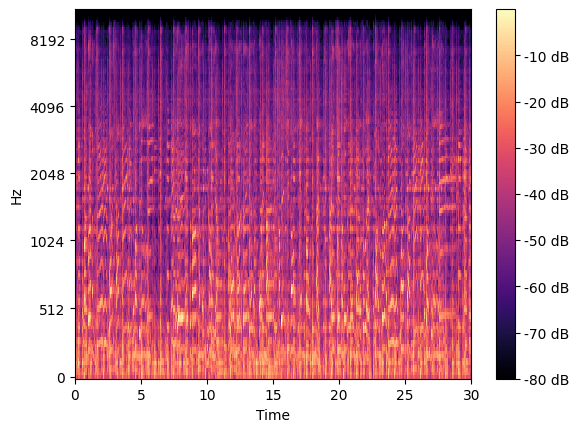

In [ ]:
import librosa.display
sample, sr = librosa.load("/content/drive/MyDrive/AML Project/genres_original/blues/blues.00000.wav")

#setting melspec features
n_mels = 128
hop_length = 512
n_fft = 1024


#extract melspec features using librosa
S = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

#convert it to DB scale
S_DB = librosa.power_to_db(S, ref=np.max)

print(sr)
print(S.shape)
print(S_DB.shape)

# #display the spectrogram
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [ ]:
audio_raw = []
classes_raw = []

N_SPLIT = 10

base_dir = "/content/drive/MyDrive/AML Project/genres_original"

first_sample, sr = librosa.load("/content/drive/MyDrive/AML Project/genres_original/blues/blues.00000.wav")
sample_length = len(first_sample) // N_SPLIT

def split_sample(orig, N):
  samples = np.array_split(orig, N)
  return samples


for genre in tqdm(os.listdir(base_dir)):
  print(" processing " + genre)

  genre_path = base_dir + '/' + genre

  for file_name in os.listdir(genre_path):
    try:
      audio, sr = librosa.load(genre_path + '/' + file_name)
      samples = np.array_split(audio, N_SPLIT)

      for sample in samples:
        if len(sample) > sample_length:
          sample = sample[:sample_length]
        else:
          sample = np.pad(sample, (0, max(0, sample_length - len(sample))))

        audio_raw.append(sample)
        classes_raw.append(genre)

    except:
      print(file_name + " unable to be loaded")

audio_raw_split = np.stack(audio_raw)
classes_raw = np.array(classes_raw)
print(audio_raw_split.shape)
print(classes_raw.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

 processing country


 10%|█         | 1/10 [00:04<00:39,  4.43s/it]

 processing jazz


 20%|██        | 2/10 [00:36<02:46, 20.82s/it]

 processing reggae


 30%|███       | 3/10 [00:39<01:29, 12.76s/it]

 processing metal


 40%|████      | 4/10 [00:43<00:55,  9.29s/it]

 processing blues


 50%|█████     | 5/10 [00:46<00:34,  6.96s/it]

 processing disco


 60%|██████    | 6/10 [00:49<00:22,  5.69s/it]

 processing classical


 70%|███████   | 7/10 [00:52<00:14,  4.79s/it]

 processing rock


 80%|████████  | 8/10 [00:56<00:09,  4.58s/it]

 processing pop


 90%|█████████ | 9/10 [00:59<00:04,  4.08s/it]

 processing hiphop


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


(9990, 66179)
(9990,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto', sparse=False)
labels = ohe.fit_transform(classes_raw[:, np.newaxis])
print(ohe.categories_)
print(labels.shape)

[array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')]
(9990, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import normalize

dataset = []

for sample_ in tqdm(audio_raw):
  mel = librosa.feature.melspectrogram(y=sample_)
  spect = librosa.power_to_db(mel, ref=1.0)
  norm_spect = normalize(spect)
  dataset.append(norm_spect)

dataset = np.stack(dataset)


100%|██████████| 9990/9990 [02:41<00:00, 61.91it/s]


In [ ]:
with open('/content/drive/MyDrive/AML Project/spectrograms.npy', 'wb') as f:
  np.save(f, dataset)

with open('/content/drive/MyDrive/AML Project/labels.npy', 'wb') as f:
  np.save(f, labels)

In [6]:
with open('/content/drive/MyDrive/AML Project/spectrograms.npy', 'rb') as f:
  dataset = np.load(f)

with open('/content/drive/MyDrive/AML Project/labels.npy', 'rb') as f:
  labels = np.load(f)

In [7]:
from sklearn.model_selection import train_test_split

dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2],1)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=22)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.optimizers import SGD

input_shape = X_train.shape[1:]

model = Sequential()
# Convolution layer 1
model.add(Conv2D(64, (3,3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Convolution layer 2
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Maxpooling layer 1
model.add (MaxPooling2D((2,2)))
# Dropout layer 1
model.add(Dropout(0.1))

# Convolution layer 3
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Convolution layer 4
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Maxpooling layer 2
model.add (MaxPooling2D((2,2)))
# Dropout layer 2
model.add(Dropout(0.1))

# Convolution layer 3
model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Convolution layer 4
model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Maxpooling layer 2
model.add (MaxPooling2D((2,2)))
# Dropout layer 3
model.add(Dropout(0.1))

#Flatten
model.add(Flatten())
# Dense layer of 128 neurons
model.add(Dense(512, activation = 'relu' ))
model.add(Dense(128, activation = 'relu' ))
model.add(Dense(10, activation = 'softmax'))

opt = keras.optimizers.Adam(learning_rate = 0.0001)
# compile model
model.compile(
  optimizer=opt,
  loss = 'categorical_crossentropy',
  metrics =['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 128, 64)      640       
                                                                 
 batch_normalization_18 (Ba  (None, 126, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 126, 128, 64)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 124, 126, 64)      36928     
                                                                 
 batch_normalization_19 (Ba  (None, 124, 126, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_19 (Activation)  (None, 124, 126, 64)     

In [9]:
checkpoint_filepath = 'checkpoint.ckpt'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True)

history = model.fit(X_train, y_train, batch_size =32, epochs =20, validation_split =0.1, callbacks=[model_checkpoint_callback])

Epoch 1/20
197/197 [==============================] - 53s 180ms/step - loss: 1.9122 - accuracy: 0.3383 - val_loss: 3.4913 - val_accuracy: 0.0871
Epoch 2/20
197/197 [==============================] - 33s 169ms/step - loss: 1.3533 - accuracy: 0.5187 - val_loss: 2.2750 - val_accuracy: 0.1771
Epoch 3/20
197/197 [==============================] - 32s 164ms/step - loss: 1.1232 - accuracy: 0.6094 - val_loss: 1.7637 - val_accuracy: 0.3986
Epoch 4/20
197/197 [==============================] - 33s 165ms/step - loss: 0.9660 - accuracy: 0.6655 - val_loss: 1.1527 - val_accuracy: 0.6014
Epoch 5/20
197/197 [==============================] - 32s 163ms/step - loss: 0.8226 - accuracy: 0.7156 - val_loss: 1.1564 - val_accuracy: 0.6286
Epoch 6/20
197/197 [==============================] - 33s 166ms/step - loss: 0.6709 - accuracy: 0.7721 - val_loss: 1.0586 - val_accuracy: 0.6543
Epoch 7/20
197/197 [==============================] - 32s 163ms/step - loss: 0.5363 - accuracy: 0.8179 - val_loss: 1.3492 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/AML Project/cnnmodel.keras')

In [5]:
model = keras.models.load_model('/content/drive/MyDrive/AML Project/cnnmodel.keras')

In [10]:
score = model.evaluate(X_test, y_test)

94/94 [==============================] - 3s 35ms/step - loss: 0.7305 - accuracy: 0.8081


In [ ]:
model.load_weights(checkpoint_filepath)
score = model.evaluate(X_test, y_test)

94/94 [==============================] - 3s 35ms/step - loss: 0.7728 - accuracy: 0.7728


94/94 [==============================] - 3s 34ms/step


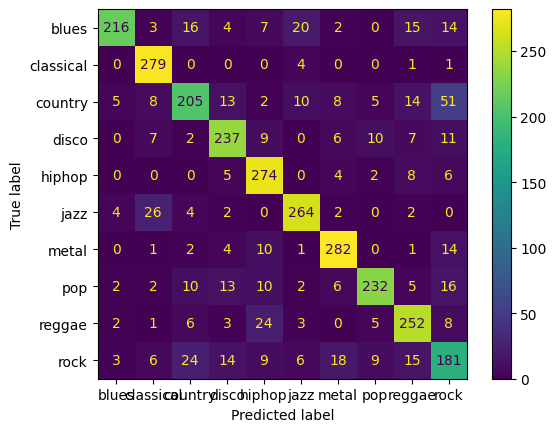

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = np.argmax(model.predict(X_test, batch_size=32), axis=1)
Y_test = np.argmax(y_test, axis=1)
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
cm = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

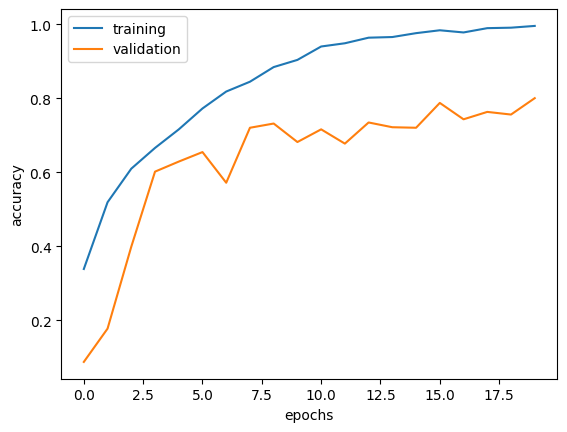

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['training', 'validation'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=10)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense

model_lstm = Sequential()

model_lstm.add(LSTM(128, dropout=0.05, recurrent_dropout=0.35, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(10, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate = 0.01)
# compile model
model_lstm.compile(
  optimizer=opt,
  loss = 'categorical_crossentropy',
  metrics =['accuracy']
)
model_lstm.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 128)               132608    
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 10)                650       
                                                                 
Total params: 141514 (552.79 KB)
Trainable params: 141514 (552.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train, y_train, batch_size =32, epochs =10, validation_split =0.1)

Epoch 1/10
197/197 [==============================] - 222s 1s/step - loss: 0.4329 - accuracy: 0.8474 - val_loss: 1.5107 - val_accuracy: 0.6257
Epoch 2/10
197/197 [==============================] - 218s 1s/step - loss: 0.4179 - accuracy: 0.8551 - val_loss: 1.5446 - val_accuracy: 0.6143
Epoch 3/10
197/197 [==============================] - 216s 1s/step - loss: 0.4078 - accuracy: 0.8595 - val_loss: 1.4509 - val_accuracy: 0.6314
Epoch 4/10
197/197 [==============================] - 228s 1s/step - loss: 0.3877 - accuracy: 0.8638 - val_loss: 1.5229 - val_accuracy: 0.6286
Epoch 5/10
197/197 [==============================] - 226s 1s/step - loss: 0.4101 - accuracy: 0.8552 - val_loss: 1.5377 - val_accuracy: 0.6129
Epoch 6/10
197/197 [==============================] - 225s 1s/step - loss: 0.3936 - accuracy: 0.8637 - val_loss: 1.5063 - val_accuracy: 0.6271
Epoch 7/10
197/197 [==============================] - 227s 1s/step - loss: 0.3660 - accuracy: 0.8700 - val_loss: 1.6136 - val_accuracy: 0.6243

In [ ]:
history = model_lstm.fit(X_train, y_train, batch_size =32, epochs =20, validation_split =0.1)

Epoch 1/20
197/197 [==============================] - 109s 533ms/step - loss: 2.2958 - accuracy: 0.1227 - val_loss: 2.2192 - val_accuracy: 0.2100
Epoch 2/20
197/197 [==============================] - 107s 544ms/step - loss: 2.0574 - accuracy: 0.2376 - val_loss: 1.8977 - val_accuracy: 0.2914
Epoch 3/20
197/197 [==============================] - 104s 528ms/step - loss: 1.8637 - accuracy: 0.3030 - val_loss: 1.7592 - val_accuracy: 0.3100
Epoch 4/20
197/197 [==============================] - 108s 552ms/step - loss: 1.7914 - accuracy: 0.3331 - val_loss: 1.7255 - val_accuracy: 0.3929
Epoch 5/20
197/197 [==============================] - 104s 529ms/step - loss: 1.6871 - accuracy: 0.3795 - val_loss: 1.6451 - val_accuracy: 0.4143
Epoch 6/20
197/197 [==============================] - 108s 551ms/step - loss: 1.7874 - accuracy: 0.3410 - val_loss: 1.7208 - val_accuracy: 0.3929
Epoch 7/20
197/197 [==============================] - 103s 524ms/step - loss: 1.6873 - accuracy: 0.3769 - val_loss: 1.6110 -

In [ ]:
model_lstm.save('/content/drive/MyDrive/AML Project/lstmmodel100.keras')

In [14]:
score = model_lstm.evaluate(X_test, y_test)

94/94 [==============================] - 8s 72ms/step - loss: 1.6132 - accuracy: 0.6086


In [4]:
model_lstm = keras.models.load_model('/content/drive/MyDrive/AML Project/lstmmodel100.keras')
model_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128, 128)          132608    
                                                                 
 lstm_16 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 186826 (729.79 KB)
Trainable params: 186826 (729.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


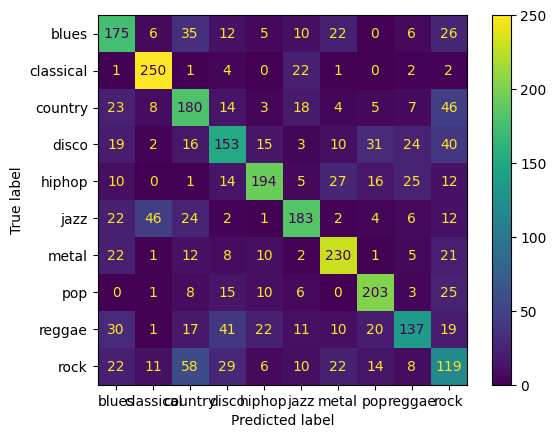

In [17]:
predictions = np.argmax(model_lstm.predict(X_test, batch_size=32), axis=1)
Y_test = np.argmax(y_test, axis=1)
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
cm = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

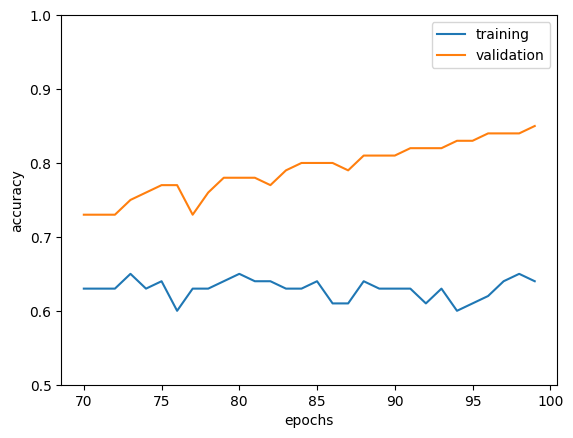

In [14]:
val_acc = np.array([0.63,0.63,0.63,0.65,0.63,0.64,0.60,0.63,0.63,0.64,
                    0.65,0.64,0.64,0.63,0.63,0.64,0.61,0.61,0.64,0.63,
                    0.63,0.63,0.61,0.63,0.60,0.61,0.62,0.64,0.65,0.64])
tr_acc = np.array([0.73,0.73,0.73,0.75,0.76,0.77,0.77,0.73,0.76,0.78,
                   0.78,0.78,0.77,0.79,0.80,0.80,0.80,0.79,0.81,0.81,
                   0.81,0.82,0.82,0.82,0.83,0.83,0.84,0.84,0.84,0.85])

x = np.arange(70,100)

plt.plot(x, val_acc, x, tr_acc)
plt.ylim([0.50,1])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['training', 'validation'])